<a href="https://colab.research.google.com/github/tadteo/WASP_AI_Course_Module3/blob/main/assignment_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Thomas Schön

Assignment responsible: Antônio Horta Ribeiro, Carl Andersson, Daniel Gedon

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health. 
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam. 


**Submission:** You submit the deliverables (see below) at <font color='red'>{TODO: where to submit}</font>

**Due Date:** June 15, 2022.

---
## Basic Tasks
Your task is to implement a classification model, train this model on the training data, and evaluate its performance on the validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks. 

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You should have at least **three (3)** submissions (for instructions on how to submit, see the very end of this notebook) where you try to improve the model architecture, improve the training or the problem formulation. In the final delivery, you should provide a short explanation of what changed between each submission and justify why you decided to make these changes.
2. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC/AP, hence you have to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you have to set the `Hardware accelerator` to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long. 

In [1]:
# Install packages
!pip install wfdb xmljson matplotlib==3.3.4 ecg_plot 
!pip install wfdb xmljson matplotlib==3.1.1 ecg_plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 27.6 MB/s 
     |████████████████████████████████| 11.5 MB 58.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 26.5 MB/s 
     |████████████████████████████████| 137 kB 40.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
  Attempting uninstall: wfdb
    Found existing installation: wfdb 3.4.1
    Uninstalling wfdb-3.4.1:
      Successfully uninstalled wfdb-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

---
## The data set

The dataset you will use in this task is a subset of the so called [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The exams were taken in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was first described in the paper "Automatic diagnosis of the 12-lead ECG using a deep neural network". https://www.nature.com/articles/s41467-020-15432-4.
The data is openly available for research upon request and is [one of the largest datasets for developing deep-learning applications electrocardiography](https://www.nature.com/articles/s41569-020-00503-2/tables/1) .


In this case, you have only a subset of it. For the training dataset you have labels. We also provide a test dataset for which you do not have the labels.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [3]:
# 1. Download dataset
!wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

--2022-06-15 06:25:34--  https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9zkqa5y5jqakdil/codesubset.tar.gz [following]
--2022-06-15 06:25:34--  https://www.dropbox.com/s/raw/9zkqa5y5jqakdil/codesubset.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfe6236209ac172ae625d515e05.dl.dropboxusercontent.com/cd/0/inline/BnMHQ1O1KQEp-QRUjQLw83OSf_Ga3ma6VtcrnT2TRQicvgqJCyrST72XzhEzNFuWYY0aZ-k3f_gDSZN5piQ0E8Np80uk1yOuZMohPTWiC0_xPtRkDZbnCz6JgH_4Wzh7erzuTtIZShBMtC3PmWX8hclWAXIqdzGj-cio3XZo0dtDV4Phzsp5_C_vnraFooX_3X0/file# [following]
--2022-06-15 06:25:34--  https://ucfe6236209ac172ae625d515e05.dl.dropboxusercontent.com/cd/0/inline/BnMHQ1O1KQEp-QRUjQLw83OSf_G

In [4]:
# 1. unzip the downloaded data set folder
!tar -xf codesubset.tar.gz


### Preprocessing

For the preprocessing we will use the GitHub repository: https://github.com/antonior92/ecg-preprocessing. 

Run the cells bellow to  Clone the GitHub repository for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).


In [5]:
# 2. clone the code files for data preprocessing
!git clone https://github.com/antonior92/ecg-preprocessing.git

Cloning into 'ecg-preprocessing'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 43 (delta 19), reused 32 (delta 12), pack-reused 0
Unpacking objects: 100% (43/43), done.


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads X sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 432x288 with 0 Axes>

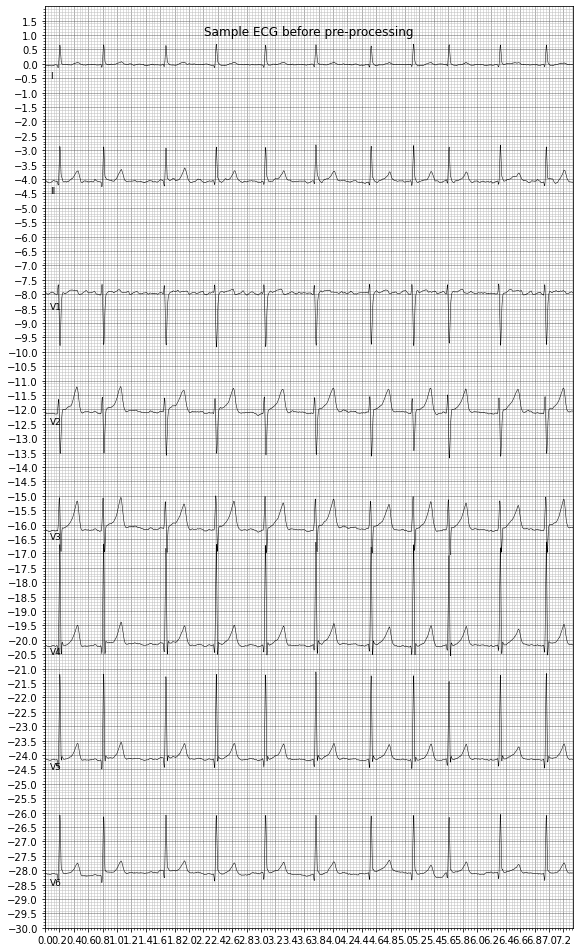

In [6]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)


# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
-  resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
-  zero padding if necessary to the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(fmt='wfdb', new_freq=400.0, new_len=4096, path='codesubset/train/TNMG100046', powerline=60.0, remove_baseline=True, save='', scale=1, use_all_leads=False)


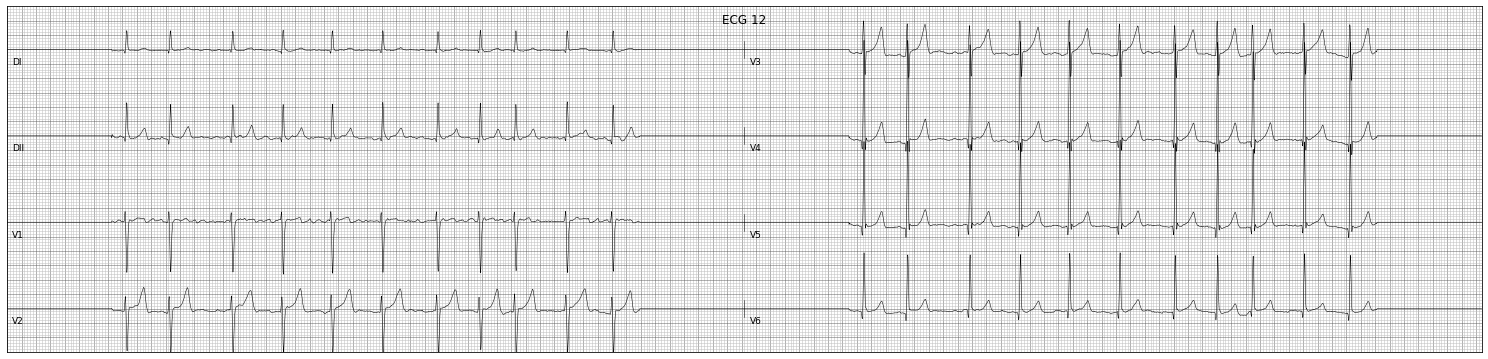

<Figure size 432x288 with 0 Axes>

In [7]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces x sequence length x number of leads)` where sequence length is 4096 and number of leads is 8. 
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [8]:
# 3. Generate train
!python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
!python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

Namespace(fmt='wfdb', input_file='codesubset/train/RECORDS.txt', new_freq=400.0, new_len=4096, out_file='codesubset/train.h5', powerline=60.0, remove_baseline=True, root_dir=None, scale=1, use_all_leads=False)
100% 10000/10000 [01:14<00:00, 134.36it/s]
Namespace(fmt='wfdb', input_file='codesubset/test/RECORDS.txt', new_freq=400.0, new_len=4096, out_file='codesubset/test.h5', powerline=60.0, remove_baseline=True, root_dir=None, scale=1, use_all_leads=False)
100% 6000/6000 [00:44<00:00, 135.19it/s]


### Coding Task 1: Data Analysis

A first step before starting to model is always to analyse the data set. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
now `data[i]` is an numpy array of the $i$th ECG exam (all time points and leads for this one exam).


dataset shape: (10000, 4096, 8)


<Figure size 432x288 with 0 Axes>

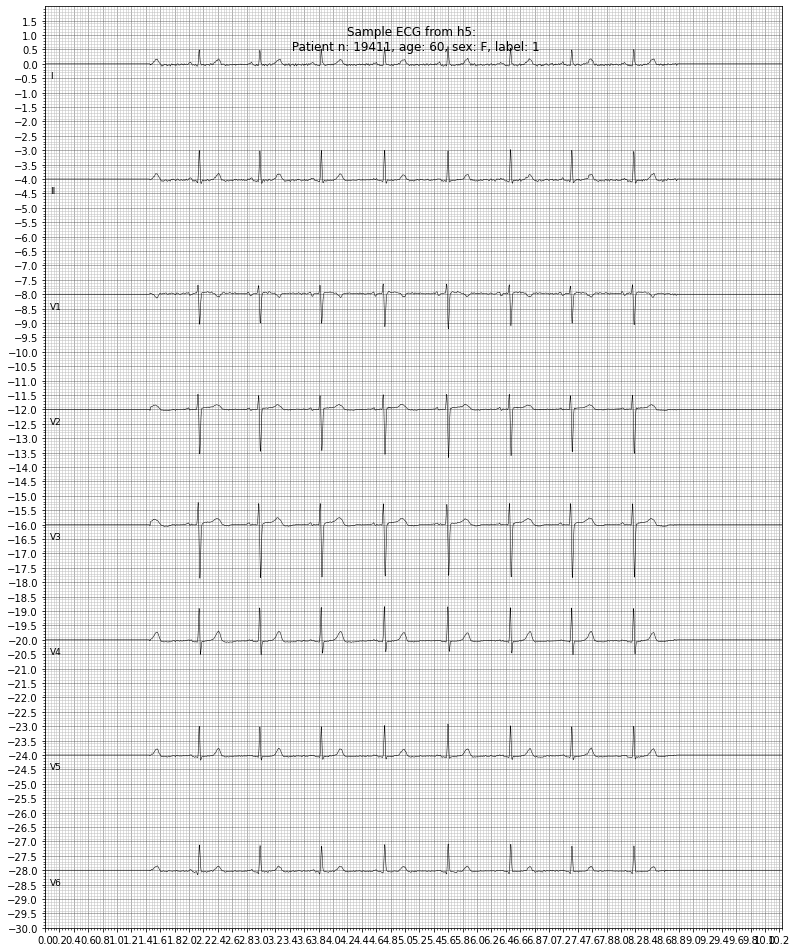

In [9]:
"""
TASK: Insert your code here
"""

import h5py
import pandas as pd
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_H5_FILE = 'codesubset/train.h5'
f= h5py.File(PATH_TO_H5_FILE, 'r')
path_to_csv_train = 'codesubset/train.csv'

# print(f.attrs)
data = f['tracings']

print(f"dataset shape: {data.shape}")

y = pd.read_csv(path_to_csv_train).to_dict('records')

# print(y)

#get a random sample of the data
i = np.random.randint(0, data.shape[0])


# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(data[i].T, sample_rate=400, style='bw', row_height=8, lead_index=lead, columns=1, title=f'Sample ECG from h5: \n Patient n: {y[i]["id_patient"]}, age: {y[i]["age"]}, sex: {y[i]["sex"]}, label: {y[i]["AF"]}')
# ecg_plot.plot(data[0], row_height=8, lead_index=lead, columns=1, title='Sample ECG from h5')
plt.show()

In [10]:
import pandas as pd

PATH_TO_CSV_FILE = 'codesubset/train.csv'
df = pd.read_csv(PATH_TO_CSV_FILE)

#print("Dataset info\n")
# print(df.info())
# print(df.head())

people_with_af = (df.loc[df['AF']==1]).shape[0]
people_without_af = (df.loc[df['AF']==0]).shape[0]
print(f"Number of people with AF: {people_with_af} --> {people_with_af*100/len(df)}%")
print(f"Number of people without AF: {people_without_af} --> {people_without_af*100/len(df)}%")
print("\n")

print("\nSex")
print("The number of males is", df.loc[df['sex']=='M'].shape[0], "which is ", int(df.loc[df['sex']=='M'].shape[0])*100/len(df), "% of the data")
print("The number of females is", df.loc[df['sex']=='F'].shape[0], "which is ", int(df.loc[df['sex']=='F'].shape[0])*100/len(df), "% of the data")
print("\n")
print("The number of males with AF", df.loc[(df['sex']=='M') & (df['AF']==1) ].shape[0], "which is ", round(int(df.loc[(df['sex']=='M') & (df['AF']==1) ].shape[0])*100/int(df.loc[df['sex']=='M'].shape[0]),2), "% of the total males")
print("The number of females with AF", df.loc[(df['sex']=='F') & (df['AF']==1) ].shape[0], "which is ", round(int(df.loc[(df['sex']=='F') & (df['AF']==1) ].shape[0])*100/int(df.loc[df['sex']=='M'].shape[0]),2), "% of the total females")

print("\nAge")

print("The number of people above 70 is", df.loc[df['age']>=70].shape[0], "which is ", int(df.loc[df['age']>=70].shape[0])*100/len(df), "% of the data")
print("The number of people above 50 is", df.loc[df['age']>=50].shape[0], "which is ", int(df.loc[df['age']>=50].shape[0])*100/len(df), "% of the data")
print("\n")

print("The percentage of people between 10-20 is ", round(int(df.loc[(df['age']<=20) & (df['age']>10)].shape[0])*100/len(df),2), "% ")
print("The percentage of people between 20-30 is ", round(int(df.loc[(df['age']<=30) & (df['age']>20)].shape[0])*100/len(df),2), "% ")
print("The percentage of people between 30-40 is ", round(int(df.loc[(df['age']<=40) & (df['age']>30)].shape[0])*100/len(df),2), "% ")
print("The percentage of people between 40-50 is ", round(int(df.loc[(df['age']<=50) & (df['age']>40)].shape[0])*100/len(df),2), "% ")
print("The percentage of people between 50-60 is ", round(int(df.loc[(df['age']<=60) & (df['age']>50)].shape[0])*100/len(df),2), "% ")
print("The percentage of people between 60-70 is ", round(int(df.loc[(df['age']<=70) & (df['age']>60)].shape[0])*100/len(df),2), "% ")
print("The percentage of people between 70-80 is ", round(int(df.loc[(df['age']<=80) & (df['age']>70)].shape[0])*100/len(df),2), "% ")
print("The percentage of people between 80-90 is ", round(int(df.loc[(df['age']<=90) & (df['age']>80)].shape[0])*100/len(df),2), "% ")
print("The percentage of people over 90 is ", round(int(df.loc[(df['age']>90) & (df['AF']==1) ].shape[0])*100/len(df),2), "% ")
print("\n")
print("The percentage of people between 10-20 with AF is", round(int(df.loc[(df['age']<=20) & (df['age']>10) & (df['AF']==1) ].shape[0])*100/int(df.loc[(df['age']<=20) & (df['age']>10)].shape[0]),2), "% ")
print("The percentage of people between 20-30 with AF is", round(int(df.loc[(df['age']<=30) & (df['age']>20) & (df['AF']==1) ].shape[0])*100/int(df.loc[(df['age']<=30) & (df['age']>20)].shape[0]),2), "% ")
print("The percentage of people between 30-40 with AF is", round(int(df.loc[(df['age']<=40) & (df['age']>30) & (df['AF']==1) ].shape[0])*100/int(df.loc[(df['age']<=40) & (df['age']>30)].shape[0]),2), "% ")
print("The percentage of people between 40-50 with AF is", round(int(df.loc[(df['age']<=50) & (df['age']>40) & (df['AF']==1) ].shape[0])*100/int(df.loc[(df['age']<=50) & (df['age']>40)].shape[0]),2), "% ")
print("The percentage of people between 50-60 with AF is", round(int(df.loc[(df['age']<=60) & (df['age']>50) & (df['AF']==1) ].shape[0])*100/int(df.loc[(df['age']<=60) & (df['age']>50)].shape[0]),2), "% ")
print("The percentage of people between 60-70 with AF is", round(int(df.loc[(df['age']<=70) & (df['age']>60) & (df['AF']==1) ].shape[0])*100/int(df.loc[(df['age']<=70) & (df['age']>60)].shape[0]),2), "% ")
print("The percentage of people between 70-80 with AF is", round(int(df.loc[(df['age']<=80) & (df['age']>70) & (df['AF']==1) ].shape[0])*100/int(df.loc[(df['age']<=80) & (df['age']>70)].shape[0]),2), "% ")
print("The percentage of people between 80-90 with AF is", round(int(df.loc[(df['age']<=90) & (df['age']>80) & (df['AF']==1) ].shape[0])*100/int(df.loc[(df['age']<=90) & (df['age']>80)].shape[0]),2), "% ")
print("The percentage of people over 90 with AF is", round(int(df.loc[(df['age']>90) & (df['AF']==1) ].shape[0])*100/int(df.loc[df['age']>90].shape[0]),2), "% ")

Number of people with AF: 3000 --> 30.0%
Number of people without AF: 7000 --> 70.0%



Sex
The number of males is 3693 which is  36.93 % of the data
The number of females is 6307 which is  63.07 % of the data


The number of males with AF 1606 which is  43.49 % of the total males
The number of females with AF 1394 which is  37.75 % of the total females

Age
The number of people above 70 is 3016 which is  30.16 % of the data
The number of people above 50 is 6925 which is  69.25 % of the data


The percentage of people between 10-20 is  2.44 % 
The percentage of people between 20-30 is  6.8 % 
The percentage of people between 30-40 is  9.57 % 
The percentage of people between 40-50 is  13.57 % 
The percentage of people between 50-60 is  19.12 % 
The percentage of people between 60-70 is  20.53 % 
The percentage of people between 70-80 is  18.78 % 
The percentage of people between 80-90 is  8.15 % 
The percentage of people over 90 is  0.68 % 


The percentage of people between 10-20 with

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary:

<br />


**Your explantions here**


Data analysis:

- Given the distribution of the data (70% healthy - 30% with AF), a naive classifier (random classifier), would have a higher occurency of FP.
- In the dataset the number of females is higher (63.07%) then the number of males(36.93%), the dataset is not balances in terms of sex
- Around 70% of people analysed are above 50 years old.
- We can notice a trend of increased AF occurencies with the increasing of the age, witha peak of 66.01 % between 80-90 years old.


Preprocessing:

Why?

- Make it easier to read the exams and therefore to diagnose heart disorders
- It also allows to have a more uniform datasample, so that the model has a more consistent input, and allows a better detection of anomalies.

What?
The preprocessing perform:
- filtering the signal with a high pass filter
- minimize the noises in the electrocardiogram (ECG) signals
- resampling the signal to a new frequency
- rescale the signal to a provided factor


---
## Model

The model class consists of two methods: 
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter (usually power of 2), **sequence length** is the number of ECG samples in the time direction (=4096) and **number of leads** is self explanatory (=8).

The `ModelBaseline` that we provide below is a 2 layer model with one convolutional layers and one linear layer. 
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [11]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8, 
                               out_channels=32, 
                               kernel_size=self.kernel_size, 
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)
        
        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)
        
        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [12]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.kernel_size = 3

        downsamplec1 = self._downsample(4096, 2056)
    
        # conv layer 1     
        self.conv1 = nn.Conv1d(in_channels=8, 
                               out_channels=32, 
                               kernel_size=self.kernel_size, 
                               stride=downsamplec1,
                               padding=self._padding(downsamplec1),
                               bias=False)

        downsamplec2 = self._downsample(2056, 1024)

        # conv layer 2
        self.conv2 = nn.Conv1d(in_channels=32, 
                               out_channels=64, 
                               kernel_size=self.kernel_size, 
                               stride=downsamplec2,
                               padding=self._padding(downsamplec2),
                               bias=False)
        # batch norm 1
        self.bn1 = nn.BatchNorm1d(num_features = 64)


        downsamplec3 = self._downsample(1024, 512)

        # conv layer 3
        self.conv3 = nn.Conv1d(in_channels=64, 
                               out_channels=128, 
                               kernel_size=self.kernel_size, 
                               stride=downsamplec3,
                               padding=self._padding(downsamplec3),
                               bias=False)
        
        self.mpool1 = nn.MaxPool1d(self.kernel_size, stride=2)


        downsamplec4 = self._downsample(512, 256)

        # conv layer 4
        self.conv4 = nn.Conv1d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=self.kernel_size, 
                               stride=downsamplec4,
                               padding=self._padding(downsamplec4),
                               bias=False)
        
        # batch norm 2
        self.bn2 = nn.BatchNorm1d(num_features = 128)


        downsamplec5= self._downsample(256, 128)


        # conv layer 5
        self.conv5 = nn.Conv1d(in_channels=128, 
                               out_channels=256, 
                               kernel_size=self.kernel_size, 
                               stride=downsamplec5,
                               padding=self._padding(downsamplec5),
                               bias=False)
        
        # max pool layer

        
       
        # dropout

        self.drop= nn.Dropout(0.8)

        self.flat = nn.Flatten() 

        # linear layer 1
        self.lin1 = nn.Linear(in_features=32768, #256*128*2, #256*128,
                             out_features=256)
        
        # linear layer 2
        self.lin2 = nn.Linear(in_features=256,
                             out_features=64)
        
        # linear layer 3
        self.lin3 = nn.Linear(in_features=64,
                             out_features=1)

        # linear layer 4
        #self.lin4 = nn.Linear(in_features=64,
        #                     out_features=1)
        
        # ReLU
        self.relu = nn.ReLU()
    
        

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)

        
    def forward(self, x):
        x= x.transpose(2,1)
        x = self.relu(self.conv1(x))
        
        x = self.relu(self.conv2(x))
        x = self.relu(self.bn1(x))
        
        x = self.relu(self.conv3(x))
        x = self.relu(self.mpool1(x))
        
        x = self.relu(self.conv4(x))
        x = self.relu(self.bn2(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.drop(x))

       
        x_flat= self.flat(x)
        x = self.lin1(x_flat)
        x = self.lin2(x)
        x = self.lin3(x)

        return x

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**Your explantions here**

We have decided to use a convulational neural network with a 5 convolutional layers with batch normalization and maxpooling applied after the convolution, while downsampling the input trough the various conv layers. The output of the convolutional layers is then passed trough a dropout layer and then flattened and passed to 3 linear layers. 

The choice of the model is based on the following considerations:
- 1D Convolutional layers are used to reduce the dimensionality of the input data, before being analysed by the flat layers.
- The maxpooling layers are used to reduce the dimensionality of the input data.
- The batch normalization is used to normalize the input data, so that the model is more robust to the different input data.
- The dropout layer is used to prevent overfitting.
- The linear layers are finally used to predict the class of the input data.

---
## Train function

The function `train(...)` is used to in every epoch to train the model. This is done by loading the training data, making predictions, comparing predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [13]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device
        traces, diagnoses = traces.to(device), diagnoses.to(device)  # use cuda/GPUs if available

        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """
        optimizer.zero_grad()
        z = model(traces)
        loss = loss_function(z, diagnoses)
        loss.backward()
        optimizer.step()

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    train_pbar.close()
    return total_loss / n_entries

---
##Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit taking gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [14]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to validation mode
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """
        with torch.no_grad():
            z = model(traces)
            loss = loss_function(z, diagnoses)
            valid_pred.append(z.detach().cpu().numpy())
            valid_true.append(diagnoses.detach().cpu().numpy())
            

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()

    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

---
## Run Training

In the code cell below we give on top some initial training hyperparameters. Further, we combine everything from above into the training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. 

Here we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data
- define the loss function
- decide and implement a validation metric to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 4, here you run the model to tune and evaluate the training and model. For this you adapt 
- the training hyperparameters
- the model architecture
- the model hyperparameters \\
based on the resulting validation metrics.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**Your explantions here**

- With learning rate of 1e-2 we noticed that the model tends to get stuck and it is not improving after some epochs. Indeed, a too high learning rate will make the learning jump over minima. Therefore we decided to decrese the learning rate to 1e-3.
- A large value for the weight decay might cause instability, therefore we decided to decrease the weight decay to 1e-2 which also gave us better performance for the AUC.
- Given the fact that we have decreased the learning rate, the number of epoches has been increased (since the reaching of the minimum can require more time, and after empirical trials we have noticed that the model is not improving after the last 2 epochs).
- An increased batch size might help to reduce the overfitting of the model, moreover it speed up the learning process since the number of iteration to loop over the entire dataset is reduced.


In [18]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 1e-3  
weight_decay = 1e-2
num_epochs = 17
batch_size = 32

In [16]:
from torch.utils.data import TensorDataset, random_split, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
#traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'], dtype=torch.float32)
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""
split_ratio_dataset = 0.7
train_size = int(split_ratio_dataset * len(dataset))
test_size = len(dataset) - train_size
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [train_size, test_size])


# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)                         
tqdm.write("Done!\n")

Use device: cuda

Building data loaders...
Done!



__main__:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


Define model...
Done!

Define optimiser...
Done!

Training...


Training Epoch  1:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9081582332761577
Epoch  1: 	Train Loss 0.014248 	Valid Loss 0.012013 	Best model -> saved


Training Epoch  2:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9327706903945111
Epoch  2: 	Train Loss 0.010511 	Valid Loss 0.010748 	Best model -> saved


Training Epoch  3:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9534219554030874
Epoch  3: 	Train Loss 0.008893 	Valid Loss 0.009690 	Best model -> saved


Training Epoch  4:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9750375214408233
Epoch  4: 	Train Loss 0.007681 	Valid Loss 0.006737 	Best model -> saved


Training Epoch  5:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.971683104631218
Epoch  5: 	Train Loss 0.006596 	Valid Loss 0.006085 	Best model -> saved


Training Epoch  6:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9724833833619212
Epoch  6: 	Train Loss 0.006288 	Valid Loss 0.006355 	


Training Epoch  7:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9756459048027444
Epoch  7: 	Train Loss 0.005563 	Valid Loss 0.005578 	Best model -> saved


Training Epoch  8:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.978946719554031
Epoch  8: 	Train Loss 0.005545 	Valid Loss 0.005473 	Best model -> saved


Training Epoch  9:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9794168096054888
Epoch  9: 	Train Loss 0.005232 	Valid Loss 0.007696 	


Training Epoch 10:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9810993782161235
Epoch 10: 	Train Loss 0.005151 	Valid Loss 0.005070 	Best model -> saved


Training Epoch 11:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9775659305317325
Epoch 11: 	Train Loss 0.004950 	Valid Loss 0.005737 	


Training Epoch 12:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9833694253859349
Epoch 12: 	Train Loss 0.004799 	Valid Loss 0.005079 	


Training Epoch 13:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9823370497427101
Epoch 13: 	Train Loss 0.004441 	Valid Loss 0.005057 	Best model -> saved


Training Epoch 14:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9824903516295026
Epoch 14: 	Train Loss 0.004704 	Valid Loss 0.004793 	Best model -> saved


Training Epoch 15:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9864365351629504
Epoch 15: 	Train Loss 0.004465 	Valid Loss 0.004271 	Best model -> saved


Training Epoch 16:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9836947898799314
Epoch 16: 	Train Loss 0.004402 	Valid Loss 0.004900 	


Training Epoch 17:   0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/94 [00:00<?, ?it/s]

AUC score is 0.9862810891938251
Epoch 17: 	Train Loss 0.004442 	Valid Loss 0.004285 	


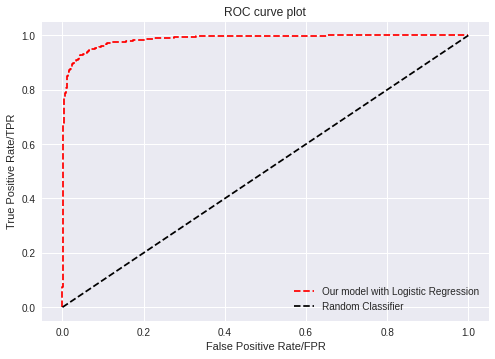

17 [0.012012984186410903, 0.010747722799579303, 0.00969042960802714, 0.006736982710659504, 0.006084807232022285, 0.006354604791849852, 0.005578174592306216, 0.005473115126291911, 0.007696468450129032, 0.005070227034389973, 0.005736784276862939, 0.005078969022879998, 0.005057331853856643, 0.004792572407672803, 0.0042711381825308, 0.0048999054717520875, 0.004285484364877144]


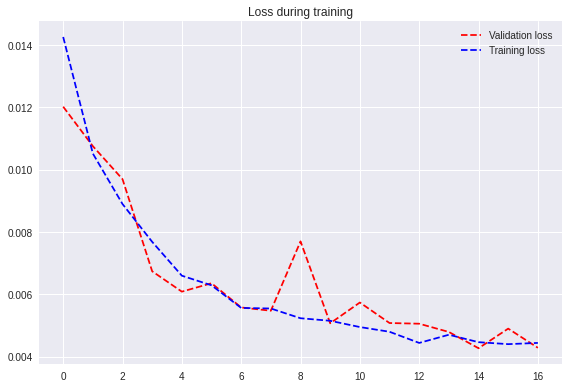

In [19]:
import sklearn.metrics as skl_metrics                                  #### REMOVE LATER ON

# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()
#model = ModelBaseline()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
loss_function = nn.BCEWithLogitsLoss()

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
lr_scheduler = None

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all = [], []

# loop over epochs
for epoch in range(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUC); Insert your code here
    This can be done e.g. in 5 lines of code
    """

    fpr, tpr, thresholds = skl_metrics.roc_curve(y_true, y_pred)
    random_pred_val = [0 for i in range(len(y_true))]
    p_fpr1, p_tpr1, _ = skl_metrics.roc_curve(y_true, random_pred_val, pos_label=1)
    auc_score = skl_metrics.roc_auc_score(y_true, y_pred)
    print("AUC score is", auc_score)

    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth') 
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step()

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

plt.style.use('seaborn')
# plt.subplots(1, figsize=(10,10))
plt.plot(fpr, tpr, linestyle='--',color='red', label='Our model with Logistic Regression')
plt.plot(p_fpr1, p_tpr1, linestyle='--', color='black', label='Random Classifier')
plt.title('ROC curve plot')
plt.xlabel('False Positive Rate/FPR')
plt.ylabel('True Positive Rate/TPR')
plt.legend(loc='best')
plt.show()

# plt.subplots(1, figsize=(10,10))
print(len(valid_loss_all), valid_loss_all, )
plt.plot(valid_loss_all, '--', color="red",  label="Validation loss")
plt.plot(train_loss_all, '--', color="blue", label="Training loss")
#plt.yscale("log")

plt.title("Loss during training")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


---
## Model Testing

Now we load our trained model and evaluate it on the test data set. We save the predictions in a csv file which have to be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obatin hard predction (0,1) instead of soft predictions (probabilities). 

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The soft and hard predictions are saved in the variables `soft_pred` and `hard_pred`.
- upload your predictions to the leaderboard online (see details below). 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()

# load stored model parameters
ckpt = torch.load('model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a team id and password. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
- For each submission you do you can attach a note for you to keep track of the submission in the leaderboard
- You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be updated and thus only the final submission will be evaluated.
- Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
- The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [ ]:
# 1. Download repository for leaderboard submission system
!git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

In [ ]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password. 
Do not change this after you have registered your team
"""
team_id = 'flat_line' #Fill in a string
password = 'GugliermoTadiello' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

In [ ]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = 'Add max pool' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**Your explantions here**

First of all we have unfortunately done the first 4 submissions without description of the model, but we will write the description in this document.

Your team id: flat_line

| Submission note | AUC   | AP    | F1    | Submission description |
| --------------- | ----  | --    | --    | ---------------------- |
|Add max pool     | 0.975 | 0.974 | 0.911 | 5 conv + 3 linear with batch norm and dropout and maxpool                   |
|(empty many conv model) | 0.962     | 0.961     | 0.889     | 5 conv + 3 linear with batch norm and dropout              |
|(empty simple multi conv layer 2)              | 0.830     | 0.809     | 0.747     | 2 conv + 3 linear layer without batch norm and dropout, different Hyperparameters and higher number of epochs                   |
|(empty simple multi conv layer 1)              | 0.845  | 0.830     | 0.678     | 2 conv + 3 linear layer without batch norm and dropout |
|(empty test base)              | 0.5     | 0.5     | 0     | Wrongly submitted test model                   |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**Your explantions here**

F1
- combines precision and recall into one metric by calculating the harmonic mean between those two. 
- for F1 to be high, both precision and recall should be high
- used in binary classification problems where you care more about the positive class
- used if there is uneven class distribution, as precision and recall may give misleading results

AP
- is the area under the precision-recall curve. Precision and recall are always between 0 and 1. Therefore, AP is between within 0 and 1 as well
- it is usually used when the data is heavily imbalanced

AUC 
- represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.  
- provides an aggregate measure of performance across all possible classification thresholds
- higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. Therefore, higher the AUC, the better the model is at distinguishing between patients with the disease and no disease. 
- mathematically, it measures the entire two-dimensional area underneath the entire ROC curve from (0,0) to (1,1)
- should not be used when your data is heavily imbalanced
- used when you care equally about positive and negative classes and/or you care about ranking predictions and not necessarily about outputting well-calibrated probabilities. 

What can happen if you only focus on AUC for example?

AUC can give a false sense of very high performance when in fact your model can be doing not that well, especially when the data is imbalanced. Indeed, there might be cases where the AUC is high while the AP or F1 is low. This happens because AUC looks at a true positive rate TPR and false positive rate FPR while PR AUC looks at positive predictive value PPV and true positive rate TPR. 




